# Forecasting Rainfall with SARIMA
## 1 . Environment

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)

# numpy
import numpy as np
print('numpy: %s' % np.__version__)

# matplotlib
import matplotlib.pylab as plt
print('matplotlib: %s' % plt.__version__)

# seaborn
import seaborn as sns
print('seaborn: %s' % sns.__version__)

# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)

# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

# statsmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
print('statsmodels: %s' % statsmodels.__version__)

#pymongo
import pymongo
import pprint
print('pymongo: %s' % pymongo.__version__)

#json
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import json

import itertools
import warnings

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

scipy: 0.19.1
numpy: 1.13.3
matplotlib: 1.13.3
seaborn: 0.8.0
pandas: 0.20.3
sklearn: 0.19.1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


statsmodels: 0.8.0
pymongo: 3.4.0


## 2. Extracting Data and Transforming Data

In [2]:
# Cria conexão com o Banco de Dados
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

# Cria Instância do Banco de Dados
db = client.AgroAnalyticsDatum

#Obtem Id da Cidade
#city_info = pd.DataFrame(list(db.cities.find({'name': "São Paulo"})))
#city_info

In [3]:
#Obtem Estações da Cidade
stations_info = pd.DataFrame(list(db.meteo_data_weather_stations.find({'city_id': ObjectId('59867b595718ddc0b8efee3b')})))
stations_info

""


,rainfall.rainfall
analysis_date,
2000-03-01,3.806452
2000-04-01,0.566667
2000-05-01,0.677419
2000-06-01,0.133333
2000-07-01,1.967742


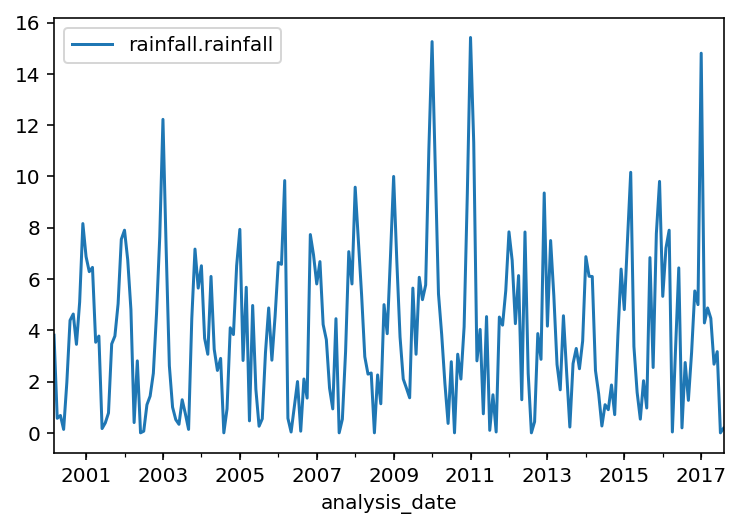

In [3]:
# Extrai dados Climáticos da Estação Selecionada
weather = list(db.meteo_data_weather_data.find({'weather_station_id': ObjectId('598f58415718dd578b4c8255')}))
weather_normalized = pd.io.json.json_normalize(weather)
df_rainfall = pd.DataFrame(weather_normalized[['analysis_date', 'rainfall.rainfall']])
df_rainfall = df_rainfall.set_index('analysis_date')
ts_rainfall = df_rainfall['2000-03-01':'2017-08-11'].groupby(pd.TimeGrouper(freq='MS')).mean()
ts_rainfall.plot()
ts_rainfall.head()

In [4]:
n_sample = ts_rainfall.shape[0]

# Cria amostra de treinamento e de teste antes de realizar a análise
n_forecast=12
n_train=n_sample-n_forecast
#ts_df
ts_train = ts_rainfall.iloc[:n_train]['rainfall.rainfall']
ts_test = ts_rainfall.iloc[n_train:]['rainfall.rainfall']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(198,)
(12,)
Training Series: 
 analysis_date
2016-04-01    0.033333
2016-05-01    3.290323
2016-06-01    6.433333
2016-07-01    0.193548
2016-08-01    2.741935
Freq: MS, Name: rainfall.rainfall, dtype: float64 

Testing Series: 
 analysis_date
2016-09-01     1.266667
2016-10-01     3.129032
2016-11-01     5.533333
2016-12-01     5.000000
2017-01-01    14.806452
Freq: MS, Name: rainfall.rainfall, dtype: float64


### 3. Setting a Baseline with Naive Forecast

In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# walk-forward validation
history = [x for x in ts_train]
predictions = list()
for i in range(len(ts_test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = ts_test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
mse = mean_squared_error(ts_test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=2.742, Expected=1.267
>Predicted=1.267, Expected=3.129
>Predicted=3.129, Expected=5.533
>Predicted=5.533, Expected=5.000
>Predicted=5.000, Expected=14.806
>Predicted=14.806, Expected=4.286
>Predicted=4.286, Expected=4.871
>Predicted=4.871, Expected=4.467
>Predicted=4.467, Expected=2.677
>Predicted=2.677, Expected=3.167
>Predicted=3.167, Expected=0.000
>Predicted=0.000, Expected=0.182
RMSE: 4.402


### 4. Model Identification (SARIMA Model Determination)

In [6]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

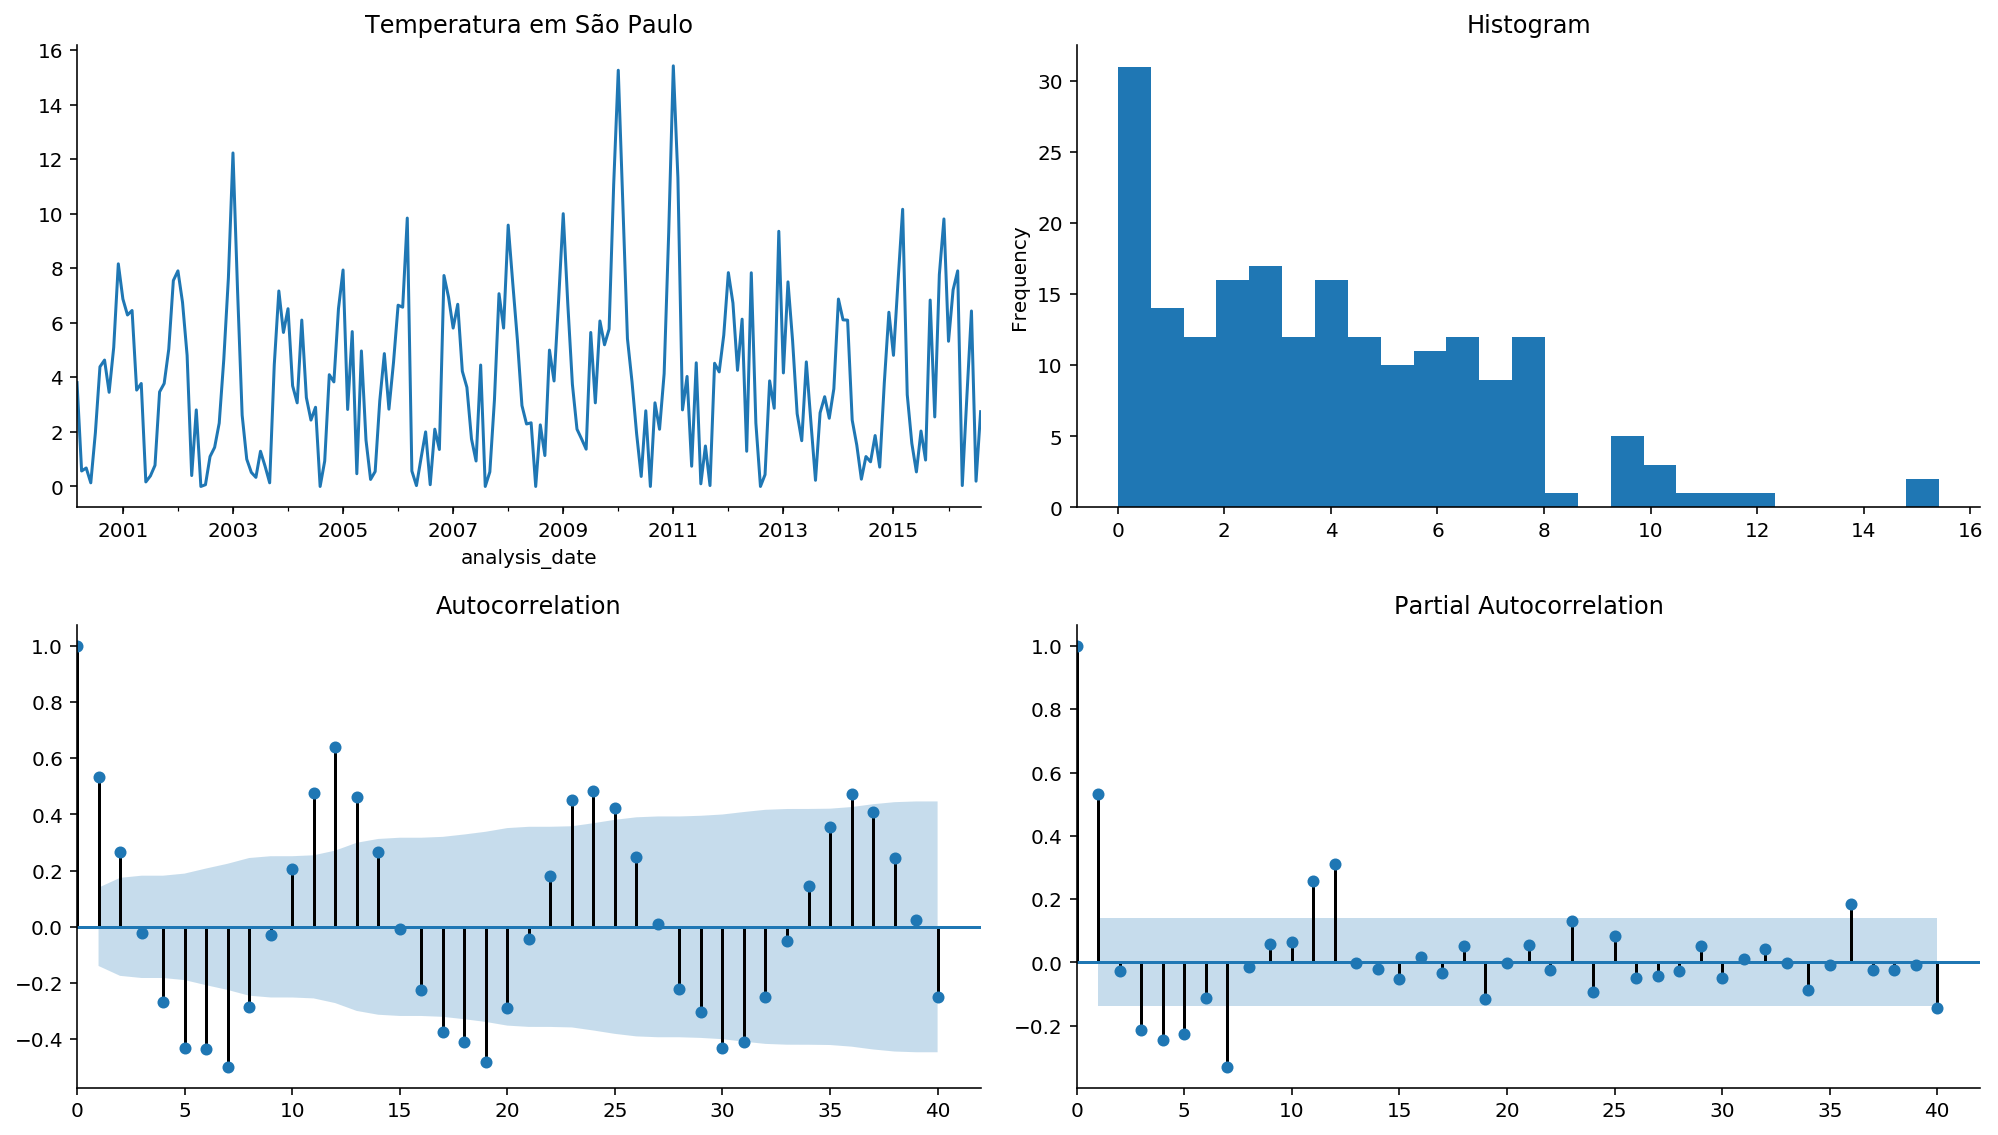

In [7]:
tsplot(ts_train, title='Temperatura em São Paulo', lags=40);

In [8]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 5)
d = range(0, 1)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 0, 4, 12)


In [9]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_param = None
best_param_seasonal = None
best_result = None

#cols = ['param','param_seasonal','AIC','BIC']
# Initialize a DataFrame to store the results
#df_results = pd.DataFrame(columns=cols)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            # initialize to store results for this parameter set
            #this_model = pd.DataFrame(columns=cols)

            results = mod.fit()
            if best_result is None:
                best_param = param
                best_param_seasonal = param_seasonal
                best_result = results
            elif results.aic < best_result.aic :
                best_param = param
                best_param_seasonal = param_seasonal
                best_result = results
            #this_model['param']=param
            #this_model['param_seasonal']=param_seasonal
            #this_model['AIC']=results.aic
            #this_model['BIC']=results.bic
            #df_results=df_results.append(this_model)
            print('ARIMA{}x{} - AIC:{} - BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
        except:
            continue
            
print(' BEST : ARIMA{}x{} - AIC:{} - BIC:{}'.format(best_param, best_param_seasonal, best_result.aic, best_result.bic))

ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:995.9445697480365 - BIC:1002.5211038094257
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:903.5878011378845 - BIC:913.4526022299681
ARIMA(0, 0, 0)x(0, 0, 3, 12) - AIC:816.0184863549584 - BIC:829.1715544777365
ARIMA(0, 0, 0)x(0, 0, 4, 12) - AIC:763.0474558850078 - BIC:779.4887910384805
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:856.9130907960474 - BIC:863.4896248574365
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:822.1650144277098 - BIC:832.0298155197934
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:761.9421567855381 - BIC:775.0952249083163
ARIMA(0, 0, 0)x(1, 0, 3, 12) - AIC:720.3092724770197 - BIC:736.7506076304924
ARIMA(0, 0, 0)x(1, 0, 4, 12) - AIC:673.0227803351781 - BIC:692.7523825193454
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:798.3090809148798 - BIC:808.1738820069634
ARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:774.820387727422 - BIC:787.9734558502001
ARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC:761.1963836081245 - BIC:777.6377187615972
ARIMA(0, 0, 0)x(2, 0, 3, 12) - AIC:717.8564590717513 - BIC:737.5860612559185

ARIMA(0, 0, 4)x(1, 0, 3, 12) - AIC:710.494799438188 - BIC:740.0892027144388
ARIMA(0, 0, 4)x(1, 0, 4, 12) - AIC:664.0187471266156 - BIC:696.9014174335609
ARIMA(0, 0, 4)x(2, 0, 0, 12) - AIC:801.0924067924254 - BIC:824.1102760072872
ARIMA(0, 0, 4)x(2, 0, 1, 12) - AIC:780.3024775290696 - BIC:806.608613774626
ARIMA(0, 0, 4)x(2, 0, 2, 12) - AIC:752.1265723510677 - BIC:781.7209756273185
ARIMA(0, 0, 4)x(2, 0, 3, 12) - AIC:708.3677993271688 - BIC:741.2504696341141
ARIMA(0, 0, 4)x(2, 0, 4, 12) - AIC:658.7010168912889 - BIC:694.8719542289288
ARIMA(0, 0, 4)x(3, 0, 0, 12) - AIC:731.3946213959255 - BIC:757.7007576414818
ARIMA(0, 0, 4)x(3, 0, 1, 12) - AIC:733.1349956896878 - BIC:762.7293989659386
ARIMA(0, 0, 4)x(3, 0, 2, 12) - AIC:726.370741821079 - BIC:759.2534121280244
ARIMA(0, 0, 4)x(3, 0, 3, 12) - AIC:705.2557085394938 - BIC:741.4266458771336
ARIMA(0, 0, 4)x(3, 0, 4, 12) - AIC:652.3085457879358 - BIC:691.7677501562703
ARIMA(0, 0, 4)x(4, 0, 0, 12) - AIC:682.832035350606 - BIC:712.4264386268568
ARI

ARIMA(1, 0, 3)x(3, 0, 0, 12) - AIC:727.5533876124998 - BIC:753.8595238580561
ARIMA(1, 0, 3)x(3, 0, 1, 12) - AIC:728.2718933182313 - BIC:757.866296594482
ARIMA(1, 0, 3)x(3, 0, 2, 12) - AIC:722.9432502831276 - BIC:755.8259205900729
ARIMA(1, 0, 3)x(3, 0, 3, 12) - AIC:708.679589493536 - BIC:744.8505268311759
ARIMA(1, 0, 3)x(3, 0, 4, 12) - AIC:657.1353811698023 - BIC:696.5945855381367
ARIMA(1, 0, 3)x(4, 0, 0, 12) - AIC:675.8341035912667 - BIC:705.4285068675175
ARIMA(1, 0, 3)x(4, 0, 1, 12) - AIC:678.9462554252598 - BIC:711.8289257322051
ARIMA(1, 0, 3)x(4, 0, 2, 12) - AIC:674.2156402990195 - BIC:710.3865776366594
ARIMA(1, 0, 3)x(4, 0, 3, 12) - AIC:673.867221475173 - BIC:713.3264258435074
ARIMA(1, 0, 3)x(4, 0, 4, 12) - AIC:655.3537955289912 - BIC:698.1012669280202
ARIMA(1, 0, 4)x(0, 0, 0, 12) - AIC:925.1697033623014 - BIC:944.8993055464687
ARIMA(1, 0, 4)x(0, 0, 1, 12) - AIC:833.8653316260829 - BIC:856.8832008409447
ARIMA(1, 0, 4)x(0, 0, 2, 12) - AIC:788.9651421186986 - BIC:815.271278364255
ARI

ARIMA(2, 0, 2)x(4, 0, 2, 12) - AIC:669.0803060001781 - BIC:705.251243337818
ARIMA(2, 0, 2)x(4, 0, 3, 12) - AIC:666.8319791193016 - BIC:706.2911834876361
ARIMA(2, 0, 2)x(4, 0, 4, 12) - AIC:660.7201913343035 - BIC:703.4676627333325
ARIMA(2, 0, 3)x(0, 0, 0, 12) - AIC:932.422126847338 - BIC:952.1517290315052
ARIMA(2, 0, 3)x(0, 0, 1, 12) - AIC:839.4282764636387 - BIC:862.4461456785004
ARIMA(2, 0, 3)x(0, 0, 2, 12) - AIC:793.9752261310699 - BIC:820.2813623766262
ARIMA(2, 0, 3)x(0, 0, 3, 12) - AIC:730.1506347910463 - BIC:759.7450380672971
ARIMA(2, 0, 3)x(0, 0, 4, 12) - AIC:685.1152197447011 - BIC:717.9978900516464
ARIMA(2, 0, 3)x(1, 0, 0, 12) - AIC:832.5535465786531 - BIC:855.5714157935149
ARIMA(2, 0, 3)x(1, 0, 1, 12) - AIC:816.0225874413495 - BIC:842.3287236869058
ARIMA(2, 0, 3)x(1, 0, 2, 12) - AIC:757.8087340855268 - BIC:787.4031373617776
ARIMA(2, 0, 3)x(1, 0, 3, 12) - AIC:714.7764231515712 - BIC:747.6590934585165
ARIMA(2, 0, 3)x(1, 0, 4, 12) - AIC:666.6552173105013 - BIC:702.8261546481411
A

ARIMA(3, 0, 2)x(0, 0, 4, 12) - AIC:708.1073025037367 - BIC:740.989972810682
ARIMA(3, 0, 2)x(1, 0, 0, 12) - AIC:839.0227154660535 - BIC:862.0405846809152
ARIMA(3, 0, 2)x(1, 0, 1, 12) - AIC:820.7680704976108 - BIC:847.0742067431671
ARIMA(3, 0, 2)x(1, 0, 2, 12) - AIC:762.2304553981396 - BIC:791.8248586743904
ARIMA(3, 0, 2)x(1, 0, 3, 12) - AIC:720.7611994705777 - BIC:753.643869777523
ARIMA(3, 0, 2)x(1, 0, 4, 12) - AIC:670.6200752322743 - BIC:706.7910125699142
ARIMA(3, 0, 2)x(2, 0, 0, 12) - AIC:791.2226748449667 - BIC:817.528811090523
ARIMA(3, 0, 2)x(2, 0, 1, 12) - AIC:770.7851884705278 - BIC:800.3795917467786
ARIMA(3, 0, 2)x(2, 0, 2, 12) - AIC:761.9974321231203 - BIC:794.8801024300657
ARIMA(3, 0, 2)x(2, 0, 3, 12) - AIC:719.3042050165324 - BIC:755.4751423541722
ARIMA(3, 0, 2)x(2, 0, 4, 12) - AIC:668.5833916739055 - BIC:708.0425960422399
ARIMA(3, 0, 2)x(3, 0, 0, 12) - AIC:719.9256085218467 - BIC:749.5200117980975
ARIMA(3, 0, 2)x(3, 0, 1, 12) - AIC:722.43509256752 - BIC:755.3177628744653
ARIM

ARIMA(4, 0, 1)x(2, 0, 1, 12) - AIC:766.4896741388354 - BIC:796.0840774150862
ARIMA(4, 0, 1)x(2, 0, 2, 12) - AIC:757.670712084047 - BIC:790.5533823909923
ARIMA(4, 0, 1)x(2, 0, 3, 12) - AIC:721.5579936444375 - BIC:757.7289309820774
ARIMA(4, 0, 1)x(2, 0, 4, 12) - AIC:672.2759625100089 - BIC:711.7351668783433
ARIMA(4, 0, 1)x(3, 0, 0, 12) - AIC:714.2835231311308 - BIC:743.8779264073816
ARIMA(4, 0, 1)x(3, 0, 1, 12) - AIC:718.1273649120412 - BIC:751.0100352189866
ARIMA(4, 0, 1)x(3, 0, 2, 12) - AIC:713.8922404960748 - BIC:750.0631778337147
ARIMA(4, 0, 1)x(3, 0, 3, 12) - AIC:710.6146081319882 - BIC:750.0738125003227
ARIMA(4, 0, 1)x(3, 0, 4, 12) - AIC:667.4187773101635 - BIC:710.1662487091925
ARIMA(4, 0, 1)x(4, 0, 0, 12) - AIC:665.3674178436668 - BIC:698.2500881506121
ARIMA(4, 0, 1)x(4, 0, 1, 12) - AIC:667.3401364817728 - BIC:703.5110738194127
ARIMA(4, 0, 1)x(4, 0, 2, 12) - AIC:663.6448670029158 - BIC:703.1040713712503
ARIMA(4, 0, 1)x(4, 0, 3, 12) - AIC:660.3532990462473 - BIC:703.1007704452763


In [11]:
mod = sm.tsa.statespace.SARIMAX(ts_train, order=(0,0,4), seasonal_order=(3,0,4,12), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit1 = mod.fit()
print(sarima_fit1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                  rainfall.rainfall   No. Observations:                  198
Model:             SARIMAX(0, 0, 4)x(3, 0, 4, 12)   Log Likelihood                -314.154
Date:                            Wed, 29 Nov 2017   AIC                            652.309
Time:                                    09:50:05   BIC                            691.768
Sample:                                03-01-2000   HQIC                           668.280
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1094      0.102      1.071      0.284      -0.091       0.310
ma.L2          0.0911      0.087   

### 5. Model Diagnostic Checking

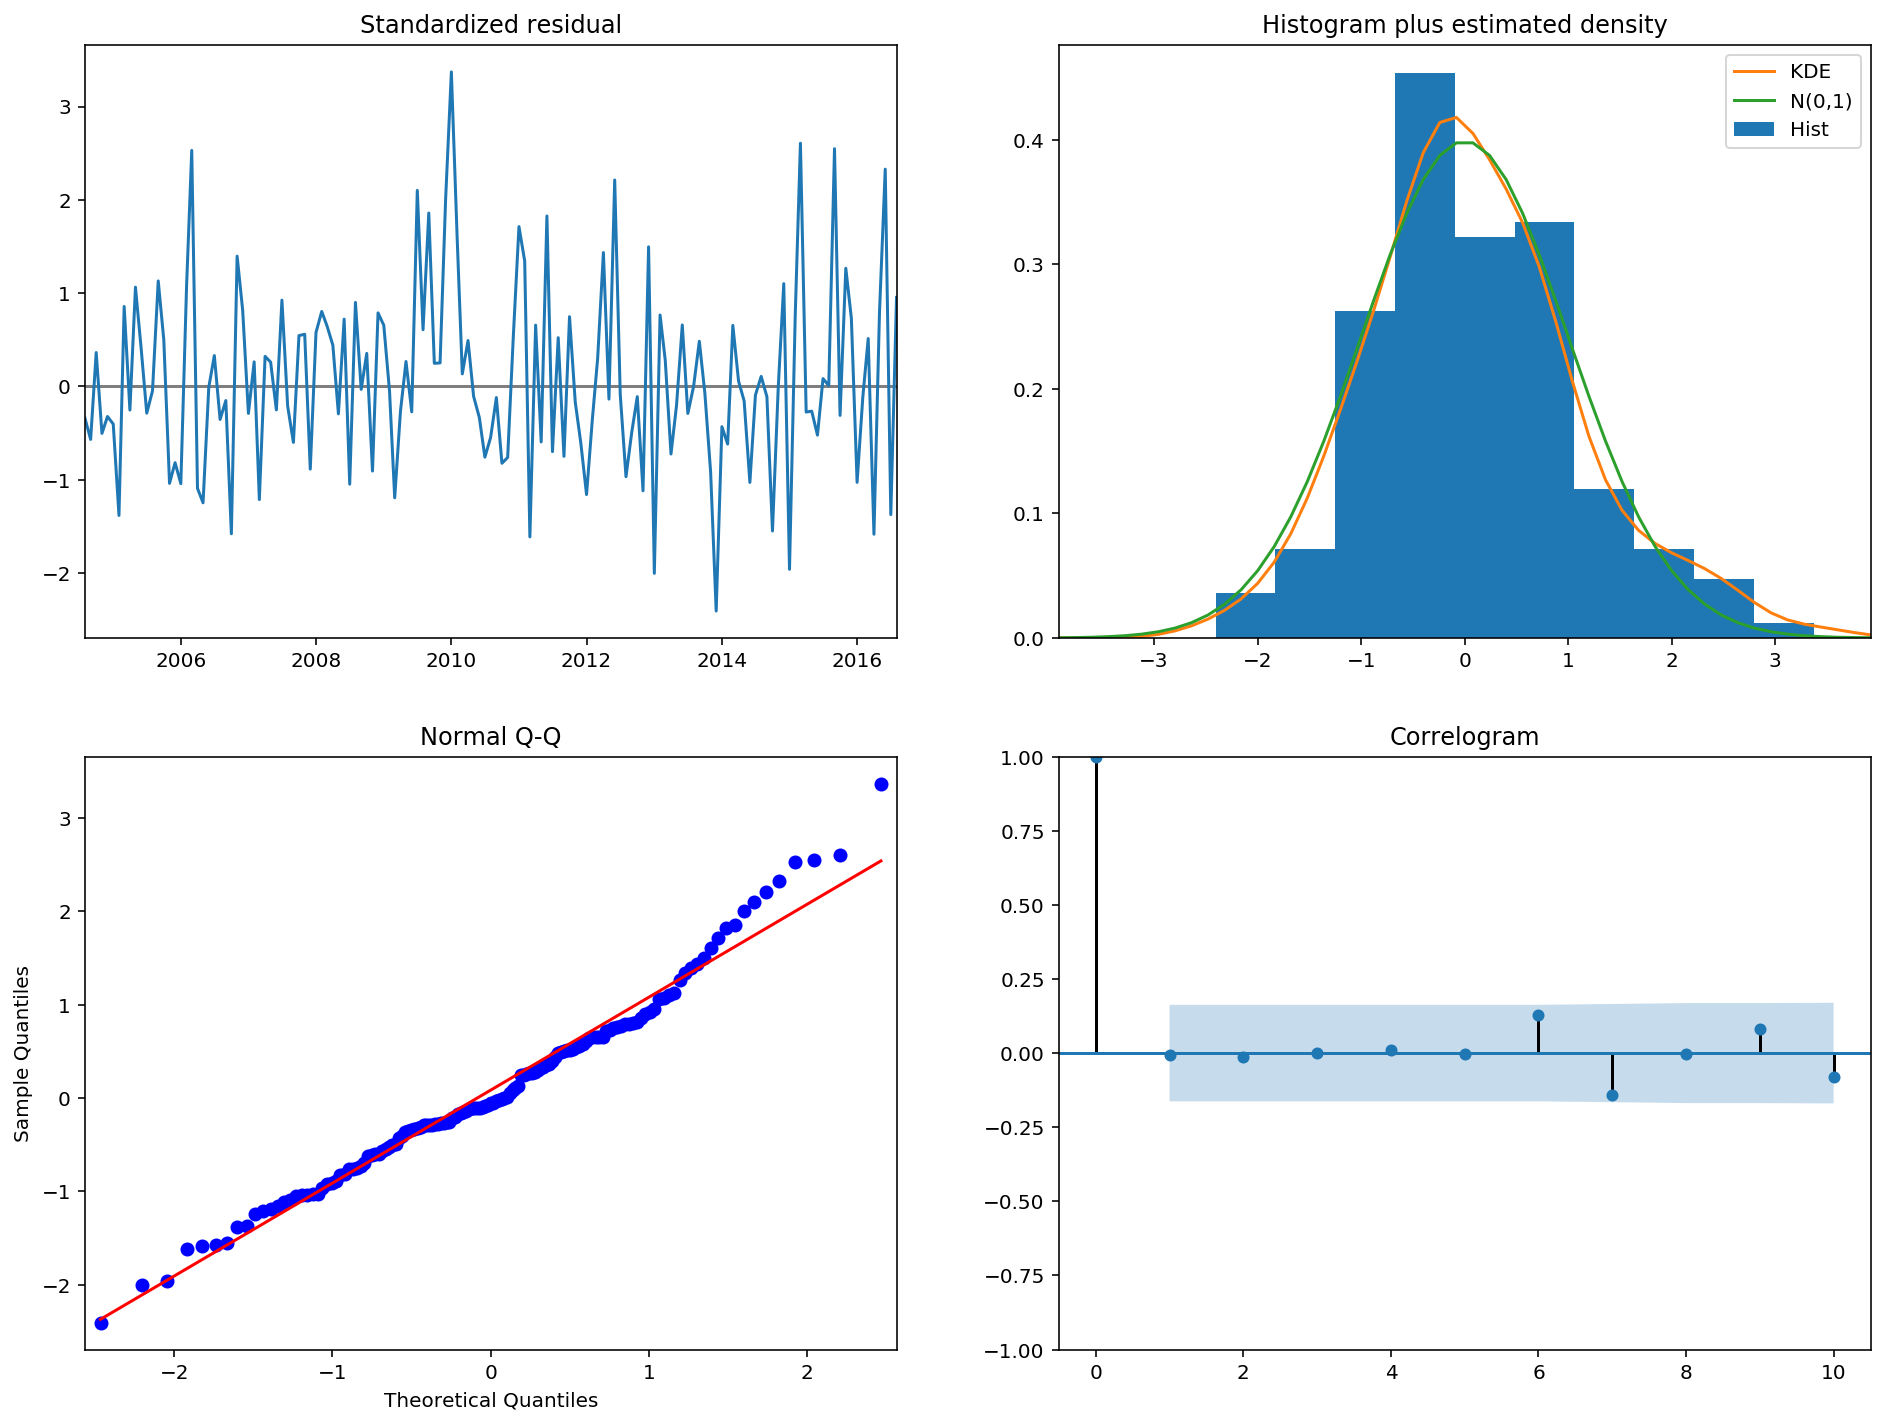

In [12]:
# Model Diagnostic

sarima_fit1.plot_diagnostics(figsize=(16, 12));

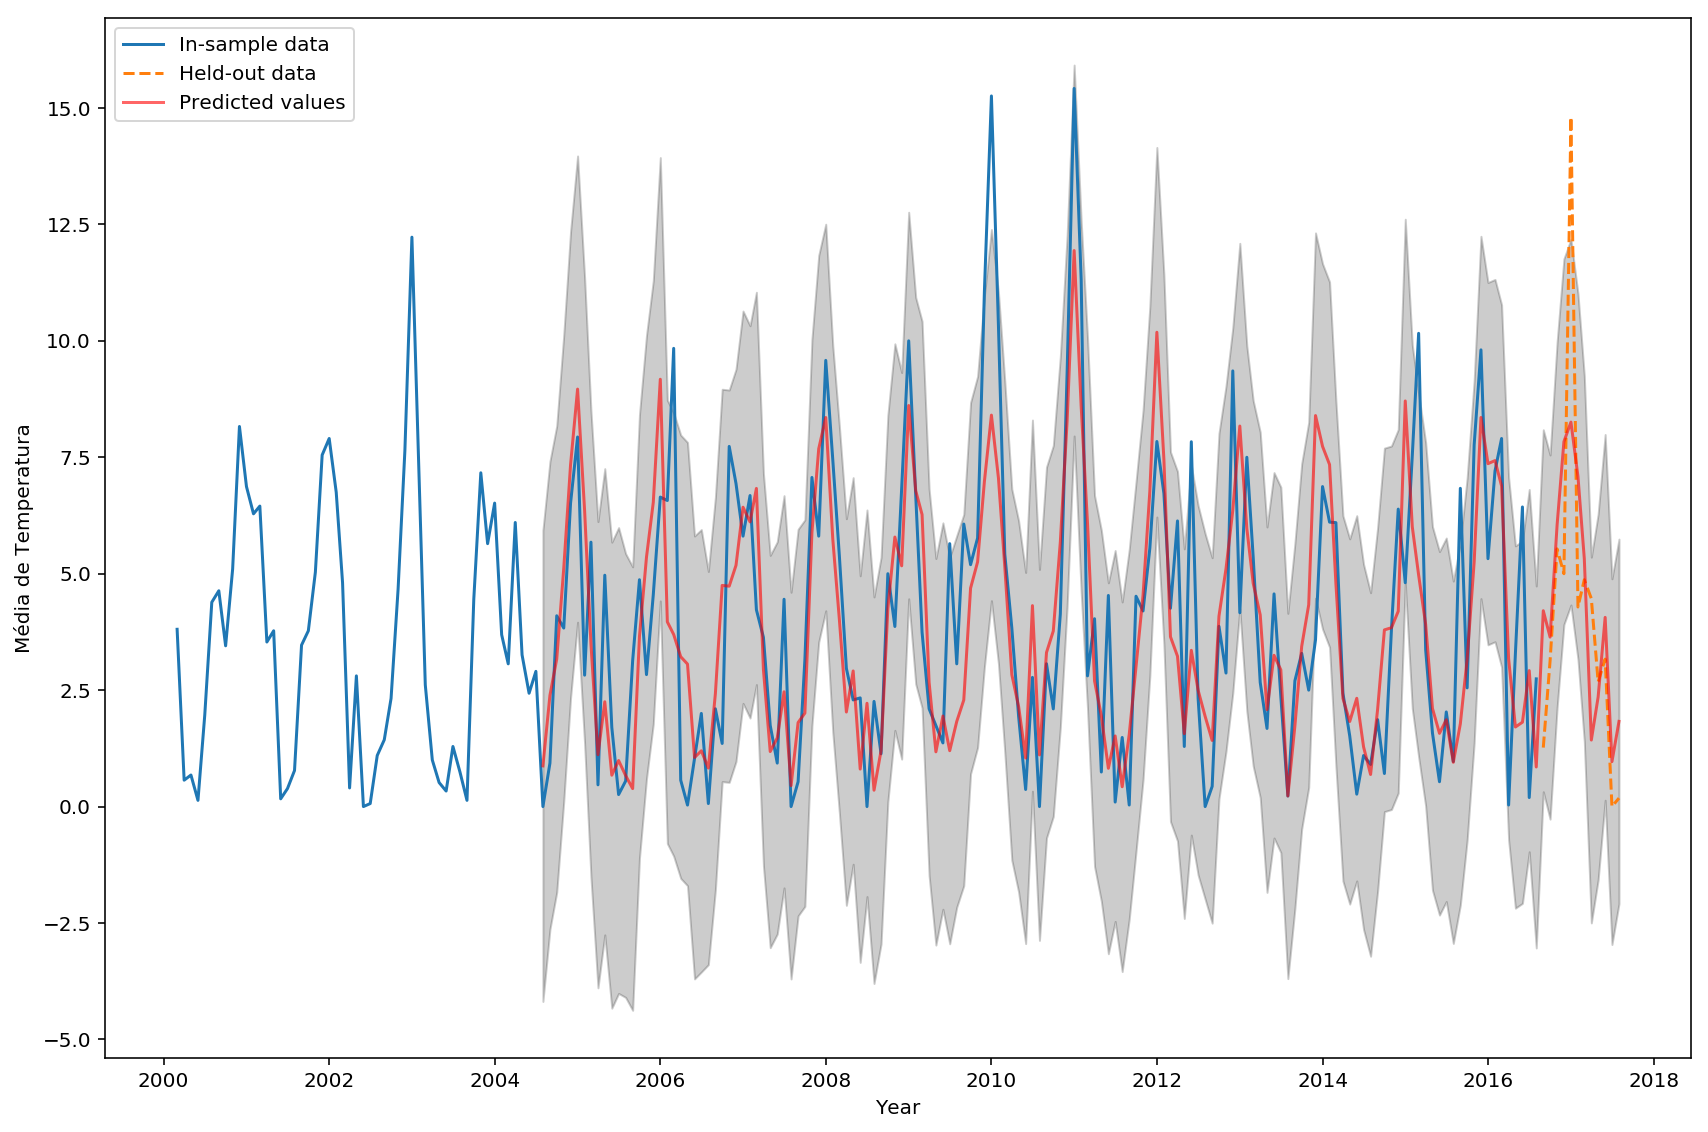

In [13]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[sarima_fit1.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = sarima_fit1.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("Média de Temperatura")
ax1.legend(loc='best');
fig.tight_layout();

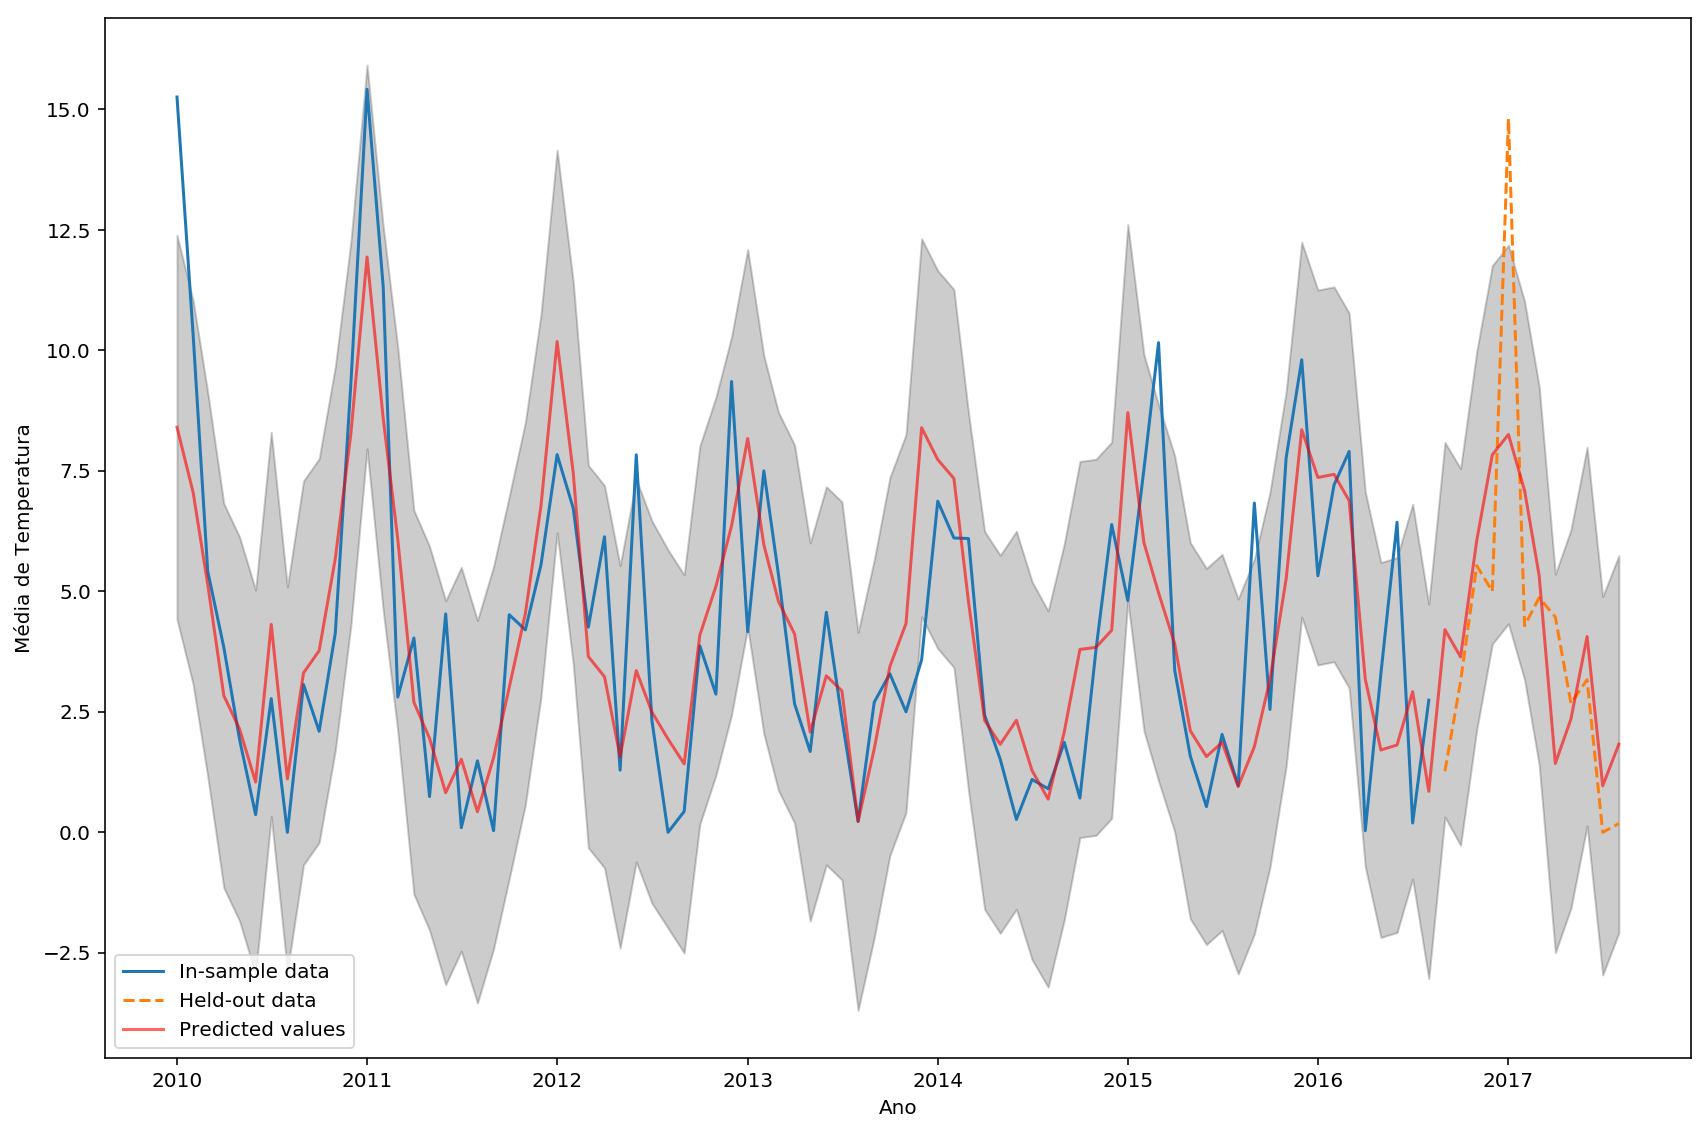

In [14]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train['2010-01-01':], label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test['2010-01-01':], label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[sarima_fit1.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = sarima_fit1.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean['2010-01-01':], 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci['2010-01-01':].index,
                 pred_ci['2010-01-01':].iloc[:, 0],
                 pred_ci['2010-01-01':].iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Ano")
ax1.set_ylabel("Média de Temperatura")
ax1.legend(loc='best');
fig.tight_layout();

In [15]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [16]:
# Training Set

rmse = get_rmse(ts_train, pred_mean.ix[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.ix[ts_train.index])
print("MAPE: ", mape)

RMSE:  2.09573115692
MAPE:  inf


In [17]:
# Test Set

rmse = get_rmse(ts_test, pred_mean.ix[ts_test.index])
print("RMSE: ", rmse)

mape = get_mape(ts_test, pred_mean.ix[ts_test.index])
print("MAPE: ", mape)

RMSE:  2.61343351812
MAPE:  inf
